# Example: Lava World using Q-Learning and SARSA
Fill me in

## Setup

In [1]:
include("CHEME-5760-L13a-CodeLib.jl");

In [2]:
using Plots
using Colors

In [3]:
function rbf(x::Tuple{Int,Int},y::Tuple{Int,Int}; σ = 1.0)::Float64
    d = sqrt((x[1] - y[1])^2 + (x[2] - y[2])^2);
    return exp(-d/(2*σ^2))
end

rbf (generic function with 1 method)

## Task 1: Build the Grid World

In [4]:
# Step 1: Build a model of the world -
number_of_rows = 10
number_of_cols = 10
nactions = 4; 
nstates = (number_of_rows*number_of_cols);
𝒮 = range(1,stop=nstates,step=1) |> collect;
𝒜 = range(1,stop=nactions,step=1) |> collect;

# setup rewards -
lava_reward = -1000.0;
charging_reward = 100.0;

# setup rewards -
rewards = Dict{Tuple{Int,Int}, Float64}()
rewards[(5,5)] =  lava_reward # lava in the (5,5) square 
rewards[(6,5)] = lava_reward # lava in the (6,5) square
rewards[(6,6)] = lava_reward # lava in the (6,6) square
rewards[(5,6)] = charging_reward    # charging station square

# do some shaping?
for s in 𝒮
    for s′ in 𝒮
        coordinate = (s,s′);
        if (haskey(rewards, coordinate) == false)
            rewards[coordinate] = charging_reward*rbf(coordinate, (5,6));
        end
    end
end

# setup set of absorbing states -
absorbing_state_set = Set{Tuple{Int,Int}}()
push!(absorbing_state_set, (5,5));
push!(absorbing_state_set, (6,5));
push!(absorbing_state_set, (6,6));
push!(absorbing_state_set, (5,6));

# walls?
soft_wall_set = Set{Tuple{Int,Int}}();
push!(soft_wall_set, (2,1));
push!(soft_wall_set, (2,2));
push!(soft_wall_set, (2,3));
push!(soft_wall_set, (7,4));
push!(soft_wall_set, (4,6));
for s in soft_wall_set
    rewards[s] = -2000.0;
end

In [5]:
# call the factory -
world_model = build(MyRectangularGridWorldModel, (
        nrows=number_of_rows, ncols=number_of_cols, rewards = rewards, defaultreward = -1.0));

## Task 2: Build the Q-learning agent

In [6]:
α = 0.70;  # learning rate
γ = 0.95; # discount rate
nstates = (number_of_rows*number_of_cols);
agent_model = build(MyQLearningAgentModel, (
    states = range(1,stop=nstates,step=1) |> collect,
    actions = range(1,stop=nactions,step=1) |> collect,
    α = α,
    γ = γ,
    Q = zeros(nstates,nactions)
));

## Task 3: Simulate

In [7]:
startstate = (10,10); # start position
number_of_iterations = 5000;
result = simulate(agent_model, world_model, startstate, number_of_iterations, ϵ = 0.5);
Q = result.Q;
my_π = policy(Q);

In [8]:
s = world_model.states[(10,10)]

100

In [9]:
Q[100,:]

4-element Vector{Float64}:
 4.137402259336936
 0.0
 8.501866578192795
 0.0

In [10]:
# move_arrows = Dict{Int,Any}();
# move_arrows[1] = "←"
# move_arrows[2] = "→"
# move_arrows[3] = "↓"
# move_arrows[4] = "↑"
# move_arrows[5] = "∅";

# for s ∈ 𝒮
#     a = my_π[s];
#     Δ = world_model.moves[a];
#     current_position = world_model.coordinates[s]
#     new_position =  current_position .+ Δ
    
#     if (in(current_position, absorbing_state_set) == true)
#         println("$(current_position) $(move_arrows[5])")
#     else
#         println("$(current_position) $(move_arrows[a]) $(new_position)")
#     end
# end

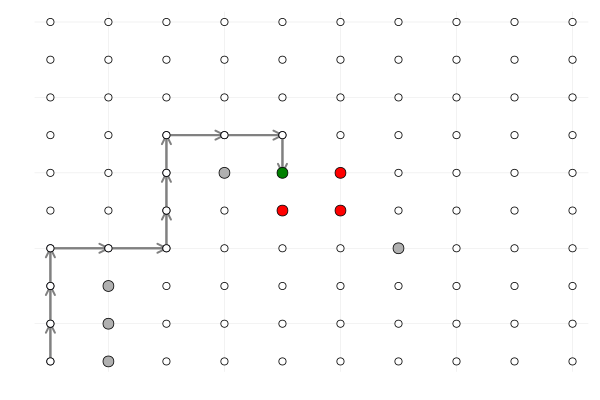

In [11]:
# draw the path -
p = plot();
initial_site = (1,1)
hit_absorbing_state = false
s = world_model.states[initial_site];
visited_sites = Set{Tuple{Int,Int}}();
push!(visited_sites, initial_site);

while (hit_absorbing_state == false)
    current_position = world_model.coordinates[s]
    a = my_π[s];
    Δ = world_model.moves[a];
    new_position =  current_position .+ Δ
    scatter!([current_position[1]],[current_position[2]], label="", showaxis=:false, msc=:black, c=:blue)
    plot!([current_position[1], new_position[1]],[current_position[2],new_position[2]], label="", arrow=true, lw=2, c=:gray)
    
    if (in(new_position, absorbing_state_set) == true || in(new_position, visited_sites) == true)
        hit_absorbing_state = true;
    else
        s = world_model.states[new_position];
        push!(visited_sites, new_position);
    end
end

# draw the grid -
for s ∈ 𝒮
    current_position = world_model.coordinates[s]
    a = my_π[s];
    Δ = world_model.moves[a];
    new_position =  current_position .+ Δ
    
    if (haskey(rewards, current_position) == true && rewards[current_position] == charging_reward)
        scatter!([current_position[1]],[current_position[2]], label="", showaxis=:false, c=:green, ms=6)
    elseif (haskey(rewards, current_position) == true && rewards[current_position] == lava_reward)
        scatter!([current_position[1]],[current_position[2]], label="", showaxis=:false, c=:red, ms=6)
    elseif (in(current_position, soft_wall_set) == true)
        scatter!([current_position[1]],[current_position[2]], label="", showaxis=:false, c=:gray69, ms=6)
    else
        scatter!([current_position[1]],[current_position[2]], label="", showaxis=:false, msc=:black, c=:white)
    end
end
current()